In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

In [2]:
lags = 12
batch_size = 256
epoch = 50

dataloader = torch.utils.data.DataLoader(
    dataset=utils.SineDataset(lags),
    batch_size=batch_size,
    drop_last=True,
    generator=torch.Generator(device=device),
    shuffle=False,
)
batch = len(dataloader)

model = utils.CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

progress = []

with tqdm(total=epoch * batch) as bar:
    for e in range(epoch):
        for i, (x, t) in enumerate(dataloader):
            bar.set_description(f"({e + 1:02}/{epoch}) | ({i + 1:02}/{batch})")
            y = model.forward(x)
            loss = criterion(y, t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.append(loss.item())
            bar.update()
            bar.set_postfix(loss=f"{loss.item():0.6}")

(50/50) | (39/39): 100%|██████████| 1950/1950 [00:13<00:00, 143.61it/s, loss=0.000970905]


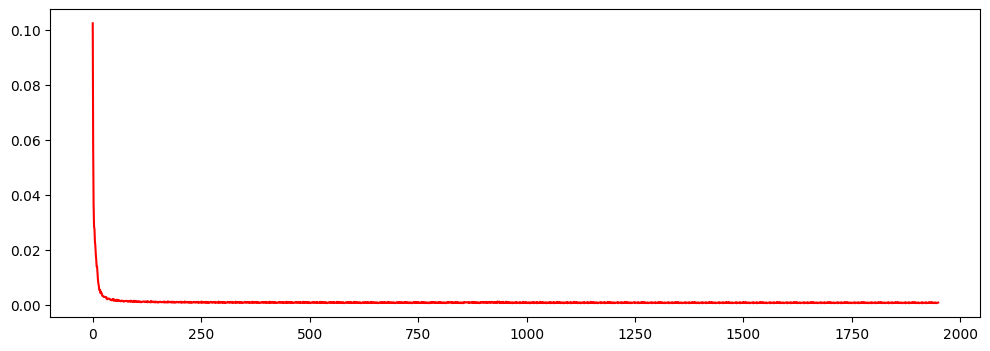

In [3]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(progress, 'r')
plt.show()
plt.close()

In [4]:
utils.save_model(model, "models/cnn.pt")
models = utils.load_models()

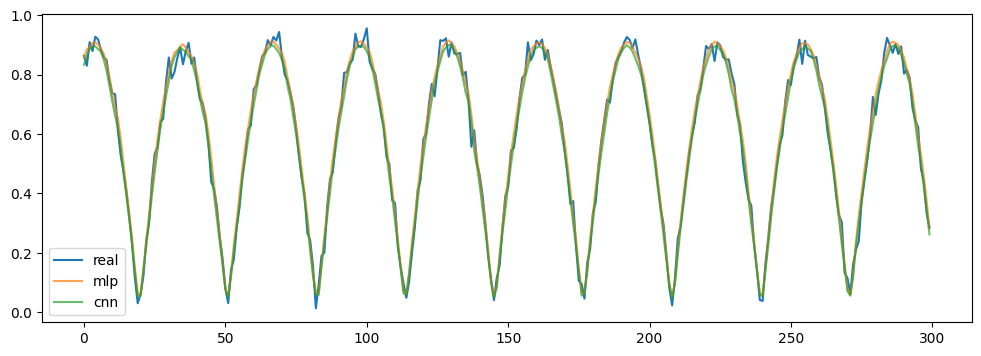

In [5]:
dataloader = torch.utils.data.DataLoader(
    dataset=utils.SineDataset(lags, train=False),
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    generator=torch.Generator(device=device),
)


real = []
for model in models.values():
    model.pred = []

for x, t in dataloader:
    real.append(t)
    for model in models.values():
        y = model.forward(x)
        model.pred.append(y)

real = torch.cat(real).detach().cpu()
for model in models.values():
    model.pred = torch.cat(model.pred).detach().cpu()

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real[:300], label='real')
for name, model in models.items():
    ax.plot(model.pred[:300], alpha=0.7, label=name)

plt.legend()
plt.show()
plt.close()


In [6]:
for model in models.values():
    err = tone.utils.attrdict.attrdict()
    err.mape = metrics.mean_absolute_percentage_error(real, model.pred)
    err.mse = metrics.mean_squared_error(real, model.pred)
    err.rmse = np.sqrt(err.mse)
    err.mae = metrics.mean_absolute_error(real, model.pred)
    err.vs = metrics.explained_variance_score(real, model.pred)
    err.r2 = metrics.r2_score(real, model.pred)
    model.err = err

df = pd.DataFrame()
df['metric'] = err.keys()

for name, model in models.items():
    df[name] = model.err.values()
df


,metric,mlp,cnn
0,mape,0.102849,0.092663
1,mse,0.001000,0.000985
2,rmse,0.031618,0.031379
3,mae,0.025337,0.025028
4,vs,0.988754,0.988692
5,r2,0.986876,0.987074
